In [1]:

import os

import matplotlib.pyplot as plt
import pandas as pd

import clip as clip
import wandb

wandb.login()

%reload_ext autoreload
%autoreload 2

wandb: Currently logged in as: yonatanlou (yonatanlou-tel-aviv-university). Use `wandb login --relogin` to force relogin


# Data Loading

In [2]:


from text_processing import load_and_process_data

df = load_and_process_data("init")
df.info()
df = df.dropna()
df = df.rename(columns={"index": "label_index"})
df = df.reset_index()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 137 entries, 0 to 136
Data columns (total 5 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   index             137 non-null    int64 
 1   שם התשובה ומקורו  137 non-null    object
 2   question          137 non-null    object
 3   label             132 non-null    object
 4   answer            137 non-null    object
dtypes: int64(1), object(4)
memory usage: 5.5+ KB


Text(0.5, 1.0, 'Histogram of answer length')

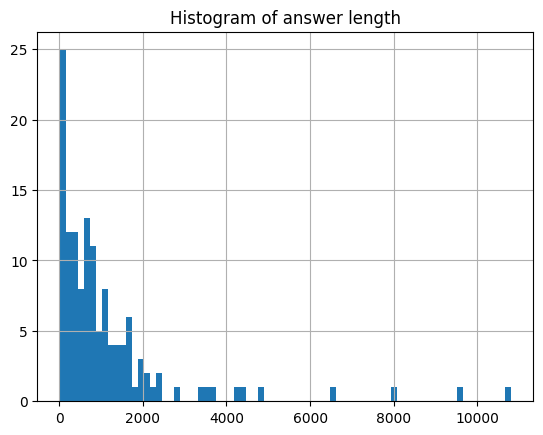

In [3]:
df["answer_length"] = df["answer"].str.split(" ").str.len()
df["answer_length"].hist(bins=75)
plt.title("Histogram of answer length")


Text(0.5, 1.0, 'Histogram of question length')

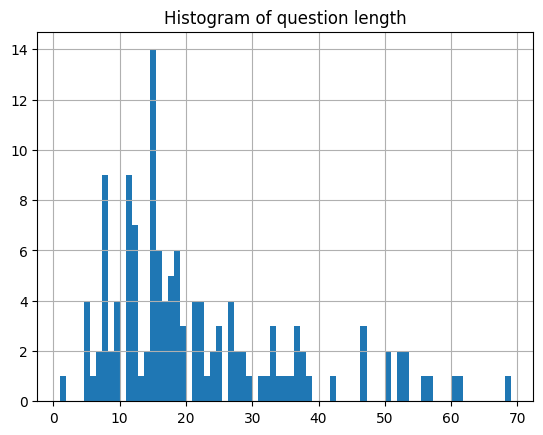

In [4]:
df["question_length"] = df["question"].str.split(" ").str.len()
df["question_length"].hist(bins=75)
plt.title("Histogram of question length")


In [5]:
df[["question_length", "answer_length"]].corr()

,question_length,answer_length
question_length,1.000000,0.056155
answer_length,0.056155,1.000000


In [6]:
import pandas as pd
import json

# Load the JSON file
with open('files/train.json', 'r') as file:
    json_data = json.load(file)

# Access the "data" key and load it into a DataFrame
q_and_a = pd.DataFrame(json_data['data'])
print(q_and_a.info())
# q_and_a.head(5)["paragraphs"][0]
q_and_a.head()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3798 entries, 0 to 3797
Data columns (total 3 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   title       3798 non-null   object
 1   source      3798 non-null   object
 2   paragraphs  3798 non-null   object
dtypes: object(3)
memory usage: 89.1+ KB
None


,title,source,paragraphs
0,מגילת העצמאות,Wikipedia,[{'context': 'לאחר שהטיוטות הראשוניות הובאו למ...
1,מדינה,Wikipedia,"[{'context': 'במהלך ההיסטוריה, ואף כיום, מתקיי..."
2,רפובליקת ויימאר,Wikipedia,[{'context': 'הממשלה הזמנית השיגה את הסכמת רוב...
3,נבחרת ישראל בכדורגל,Wikipedia,[{'context': 'ב-1 באפריל 2012 חנכה ההתאחדות לכ...
4,ליברטריאניזם,Wikipedia,[{'context': 'מבקרי הליברטריאניזם משמאל ומימין...


In [7]:
relevant_titles = ['שבת שירה', 'בראשית', 'רש"י', 'ברכת המזון', 'הר הבית', 'טעמי המקרא', 'שבע מצוות בני נח',
                   'ברית המילה', 'תנ"ך', 'מרד בר כוכבא', 'יציאת מצרים', 'פורים', 'תורה', 'רמב"ם', 'שבת', 'הורדוס',
                   'יצחק כדורי', 'תפילת הדרך', 'דוד ובת שבע', 'יוסף קארו', 'הלכה', 'שולחן ערוך', 'היסטוריה של עם ישראל',
                   'המבול', 'אברהם', 'ממלכת הכוזרים', 'דוד בן-גוריון', 'ברית מילה', 'ברכות השחר', 'אליעזר בן-יהודה',
                   'מגילת העצמאות', 'ירושלים', 'גירוש ספרד', 'אברהם אבן עזרא', 'קבר הבאבא סאלי', 'כשרות', 'גיור',
                   'חוק האזרחות והכניסה לישראל', 'מזוזה', 'מעמד האישה ביהדות', 'תהילים', 'ההגנה', 'עשרת הדיברות',
                   'ברכת הגומל', 'המרד הגדול', 'אלוהים', 'כנסיית הקבר', 'אבלות (יהדות)', 'מגילת קהלת',
                   'בית המקדש הראשון', 'שמשון', 'מגדל בבל', 'תנועת החסידות', 'גלות בבל', 'מרדכי בן-פורת', 'השואה',
                   'תחיית הלשון העברית', 'יהדות מרוקו', 'מנחם מנדל שניאורסון', 'בית המקדש', 'אוריה החתי']


def generate_ext_q_and_a(q_and_a, relevant_titles, answer_length):
    results = []
    tmp_q_and_a = q_and_a[q_and_a["title"].isin(relevant_titles)]
    for i, row in tmp_q_and_a.iterrows():

        paragraphs = row['paragraphs']
        title = row["title"]

        # For each paragraph, access the context and questions
        for paragraph in paragraphs:
            context = paragraph['context']
            qas = paragraph['qas']

            # For each Q&A pair, extract the question and answer
            for qa in qas:
                tmp_result = {}
                question = qa['question']

                answer = qa['answers'][0]
                start = answer['answer.start']
                answer_text = answer['text']

                before = (start - answer_length) if start > answer_length else start

                extracted_answer = context[before:start + answer_length]
                combined_answer = extracted_answer + ". לכן התשובה היא " + answer_text

                tmp_result.update({"questions_q_a": question, "answers_q_a": combined_answer, "title": title})
                results.append(tmp_result)
    return pd.DataFrame(results)
    # return questions_q_a, answers_q_a


from transformers import AutoTokenizer, AutoModel
from tqdm import tqdm  # For progress bar

berel_tokenizer = AutoTokenizer.from_pretrained("dicta-il/BEREL")
berel_model = AutoModel.from_pretrained("dicta-il/BEREL")


def simple_chunking(text, chunk_size=128, overlap=0):
    words = text.split()
    chunks = []

    for i in range(0, len(words), chunk_size - overlap):
        chunk = ' '.join(words[i:i + chunk_size])
        chunks.append(chunk)

    return chunks


def get_berel_embeddings(texts, chunk_size=300, overlap=30):
    all_embeddings = []

    for text in tqdm(texts):
        chunked_text = simple_chunking(text, chunk_size=chunk_size, overlap=overlap)
        embedding = get_berel_embedding_from_chunked_text(chunked_text)
        all_embeddings.append(embedding)

    return np.vstack(all_embeddings)


def get_berel_embedding_from_chunked_text(texts: list):
    all_embeddings = []

    for text in texts:
        inputs = berel_tokenizer(
            text,
            return_tensors="pt",
            padding=True,
            truncation=True,
            max_length=berel_tokenizer.model_max_length,
        )
        with torch.no_grad():
            outputs = berel_model(**inputs)
        embedding = outputs.last_hidden_state.mean(dim=1).cpu().numpy()

        all_embeddings.append(embedding)
    return np.vstack(all_embeddings).mean(axis=0)


def train(question_embeddings_plus, answer_embeddings_plus):
    wandb.finish()

    wandb.init(
        # Set the project where this run will be logged
        project="RabbanicWisdomAI",
        # We pass a run name (otherwise it’ll be randomly assigned, like sunshine-lollypop-10)
        name=f"exp-2",
        # Track hyperparameters and run metadata
        config={
            "learning_rate": 1e-4,
            "model": "ClipModel",
            "epochs": 100,
            "batch_size": 16,
            "dropout": 0.25,  # 0.25
            "latent_dim": 768,  # output dim of embedding
            "hidden_dim": 512,
            "imgdim": question_embeddings_plus.shape[1],  # input dim of image
            "ppidim": answer_embeddings_plus.shape[1],  # input dim of ppi
            "n_sample": answer_embeddings_plus.shape[0],
            "nce_w": 0,
            "clip_w": 1,
            "nce_t": 0.5,  #temp
            "unif_w": 0,
            "align_w": 0,
            "verbose": False
        },
    )
    resultsdir = f"results/exp-2"  # where to save the embeddings and model artifact
    if not os.path.exists(resultsdir):
        os.makedirs(resultsdir, exist_ok=True)
    idxs = list(range(len(answer_embeddings_plus)))
    model = clip.clip_fit_predict(
        resultsdir=resultsdir,
        index_names=idxs,
        data_ppi=answer_embeddings_plus,
        data_img=question_embeddings_plus,
        config=wandb.config,
        wandb=wandb,
    )
    wandb.finish()
    return model

Some weights of BertModel were not initialized from the model checkpoint at dicta-il/BEREL and are newly initialized: ['bert.pooler.dense.bias', 'bert.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [16]:
import pandas as pd
import random
import torch
from datetime import datetime

os.environ["WANDB_SILENT"] = "true"

CHUNK_SIZE = 400
OVERLAP_SIZE = 20


def load_data():
    # Assuming df and q_and_a are defined elsewhere
    global df, q_and_a
    return df, q_and_a


def split_data(df, random_split=False, train_size=0.8):
    if random_split:
        train_idxs = random.sample(list(df.index), int(train_size * df.shape[0]))
        df_train = df[df.index.isin(train_idxs)]
        df_test = df[~df.index.isin(train_idxs)]
    else:
        train_size = int(train_size * df.shape[0])
        df_train = df.iloc[:train_size, ]
        df_test = df.iloc[train_size:, ]

    return df_train, df_test


def get_embeddings(texts, chunk_size=CHUNK_SIZE, overlap=OVERLAP_SIZE):
    # Assuming get_berel_embeddings is defined elsewhere
    return get_berel_embeddings(texts, chunk_size=chunk_size, overlap=overlap)


def train_model(question_embeddings, answer_embeddings):
    # Assuming train function is defined elsewhere
    return train(question_embeddings, answer_embeddings)


from sklearn.metrics import accuracy_score
from sklearn.metrics.pairwise import cosine_similarity
from scipy.optimize import linear_sum_assignment


# Evaluate using argmax (original approach)
def evaluate_model_argmax(model, question_embeddings, answer_embeddings):
    with torch.no_grad():
        q_features, a_features = model.get_embedding(
            torch.from_numpy(answer_embeddings),  # Convert to tensor
            torch.from_numpy(question_embeddings)  # Convert to tensor
        )

    # Normalize embeddings
    q_features = q_features / q_features.norm(dim=-1, keepdim=True)
    a_features = a_features / a_features.norm(dim=-1, keepdim=True)

    # Compute cosine similarity matrix using sklearn's cosine_similarity
    similarity_submatrix = cosine_similarity(q_features.cpu().numpy(), a_features.cpu().numpy())

    # Evaluate argmax-based accuracy
    true_labels = np.arange(similarity_submatrix.shape[0])
    predicted_labels = np.argmax(similarity_submatrix, axis=1)

    return accuracy_score(true_labels, predicted_labels)


# KNN-based evaluation using PyTorch and NumPy
def knn_score(similarity_submatrix, k):
    predictions = []
    # Perform kNN for each row and check if the row index is among the top k neighbors
    for i in range(similarity_submatrix.shape[0]):
        row = similarity_submatrix[i, :]
        top_k = np.argsort(row)[-k:]  # Get indices of the top k values (ascending order)
        if i in top_k:
            predictions.append(1)  # True prediction
        else:
            predictions.append(0)  # False prediction

    true_labels = np.ones(similarity_submatrix.shape[0])

    # Calculate accuracy score
    accuracy = accuracy_score(true_labels, predictions)
    return accuracy, predictions


# Hungarian-based evaluation using PyTorch and NumPy
def hungarian_score(similarity_submatrix):
    # Convert similarities to costs by subtracting from 1 (because the Hungarian algorithm finds minimum cost)
    cost_matrix = 1 - similarity_submatrix

    # Perform matching using the Hungarian algorithm
    row_indices, col_indices = linear_sum_assignment(cost_matrix)

    accuracy = (row_indices == col_indices).mean()
    return accuracy, col_indices


# Main evaluation function that includes all methods
def evaluate_model(model, question_embeddings, answer_embeddings):
    with torch.no_grad():
        q_features, a_features = model.get_embedding(
            torch.from_numpy(answer_embeddings),  # Convert to tensor
            torch.from_numpy(question_embeddings)  # Convert to tensor
        )

    # Normalize embeddings
    q_features = q_features / q_features.norm(dim=-1, keepdim=True)
    a_features = a_features / a_features.norm(dim=-1, keepdim=True)

    # Compute cosine similarity matrix using sklearn's cosine_similarity
    similarity_submatrix = cosine_similarity(q_features.cpu().numpy(), a_features.cpu().numpy())

    # Argmax-based evaluation
    accuracy_argmax = evaluate_model_argmax(model, question_embeddings, answer_embeddings)

    # KNN and Hungarian-based evaluation
    knn_acc = {}
    for k in [2, 3, 5]:
        accuracy_knn, _ = knn_score(similarity_submatrix, k=k)
        knn_acc[k] = accuracy_knn
    accuracy_hungarian, _ = hungarian_score(similarity_submatrix)

    return accuracy_argmax, knn_acc, accuracy_hungarian


def generate_qa(q_and_a, relevant_titles, num_questions):
    return generate_ext_q_and_a(q_and_a, relevant_titles, num_questions)


def set_seed_globally(seed=42):
    # Set seeds
    np.random.seed(seed)
    random.seed(seed)
    torch.manual_seed(seed)
    if torch.cuda.is_available():
        torch.cuda.manual_seed(seed)
        torch.cuda.manual_seed_all(seed)


def run_experiment(constant_embeddings, model_original):
    q_emb_test = constant_embeddings["q_emb_test"]
    a_emb_test = constant_embeddings["a_emb_test"]

    q_emb_combined = constant_embeddings["q_emb_combined"]
    a_emb_combined = constant_embeddings["a_emb_combined"]

    print(f"training combined model with {q_emb_combined.shape=}")
    model_combined = train_model(q_emb_combined, a_emb_combined)

    accuracy_argmax_origin, accuracy_knn_origin, accuracy_hungarian_origin = evaluate_model(model_original, q_emb_test,
                                                                                            a_emb_test)
    accuracy_argmax_combined, accuracy_knn_combined, accuracy_hungarian_combined = evaluate_model(model_combined,
                                                                                                  q_emb_test,
                                                                                                  a_emb_test)
    accuracy_knn_origin = {f"accuracy_no_q_a_knn={k}": acc for k, acc in accuracy_knn_origin.items()}
    accuracy_knn_combined = {f"accuracy_plus_q_a_knn={k}": acc for k, acc in accuracy_knn_combined.items()}

    res = {
        "accuracy_plus_q_a_argmax": accuracy_argmax_combined,
        "accuracy_no_q_a_argmax": accuracy_argmax_origin,
        "accuracy_plus_q_a_hungarian": accuracy_hungarian_combined,
        "accuracy_no_q_a_hungarian": accuracy_hungarian_origin,

    }
    res.update(accuracy_knn_origin)
    res.update(accuracy_knn_combined)

    return res





In [17]:
questions = df["question"].to_list()
answers = df["answer"].to_list()

relevant_titles = ['שבת שירה', 'בראשית', 'רש"י', 'ברכת המזון', 'הר הבית', 'טעמי המקרא', 'שבע מצוות בני נח',
                   'ברית המילה', 'תנ"ך', 'מרד בר כוכבא', 'יציאת מצרים', 'פורים', 'תורה', 'רמב"ם', 'שבת', 'הורדוס',
                   'יצחק כדורי', 'תפילת הדרך', 'דוד ובת שבע', 'יוסף קארו', 'הלכה', 'שולחן ערוך', 'היסטוריה של עם ישראל',
                   'המבול', 'אברהם', 'ממלכת הכוזרים', 'דוד בן-גוריון', 'ברית מילה', 'ברכות השחר', 'אליעזר בן-יהודה',
                   'מגילת העצמאות', 'ירושלים', 'גירוש ספרד', 'אברהם אבן עזרא', 'קבר הבאבא סאלי', 'כשרות', 'גיור',
                   'חוק האזרחות והכניסה לישראל', 'מזוזה', 'מעמד האישה ביהדות', 'תהילים', 'ההגנה', 'עשרת הדיברות',
                   'ברכת הגומל', 'המרד הגדול', 'אלוהים', 'כנסיית הקבר', 'אבלות (יהדות)', 'מגילת קהלת',
                   'בית המקדש הראשון', 'שמשון', 'מגדל בבל', 'תנועת החסידות', 'גלות בבל', 'מרדכי בן-פורת', 'השואה',
                   'תחיית הלשון העברית', 'יהדות מרוקו', 'מנחם מנדל שניאורסון', 'בית המקדש', 'אוריה החתי']

q_and_a_processed = generate_qa(q_and_a, relevant_titles, int(df["answer_length"].median()))
questions_qa = q_and_a_processed["questions_q_a"].to_list()
answers_qa = q_and_a_processed["answers_q_a"].to_list()
import pickle

embeddings_path = "embeddings.pkl"
if os.path.exists(embeddings_path):
    with open(embeddings_path, "rb") as f:
        all_embeddings = pickle.load(f)
        print(f"Loaded the embeddings: {list(all_embeddings.keys())}")
else:
    questions_embeddings = get_embeddings(questions)
    answers_embeddings = get_embeddings(answers)
    questions_qa_embeddings = get_embeddings(questions_qa)
    answers_qa_embeddings = get_embeddings(answers_qa)
    all_embeddings = {"questions_embeddings": questions_embeddings, "answers_embeddings": answers_embeddings,
                      "questions_qa_embeddings": questions_qa_embeddings,
                      "answers_qa_embeddings": answers_qa_embeddings}
    with open(embeddings_path, "wb") as f:
        pickle.dump(all_embeddings, f)


Loaded the embeddings: ['questions_embeddings', 'answers_embeddings', 'questions_qa_embeddings', 'answers_qa_embeddings']


In [66]:
import os

os.environ["TOKENIZERS_PARALLELISM"] = "false"


def main(df, q_and_a_processed, all_embeddings, num_qas, relevant_titles, iter=5, random_split=False):
    results = []
    q_and_a_processed_filtered = q_and_a_processed[q_and_a_processed["title"].isin(relevant_titles)]
    for i in range(iter):
        i += 5
        print(f"{datetime.now()} - {i=}")
        set_seed_globally(i)
        df_train, df_test = split_data(df, random_split)

        q_emb_train = all_embeddings["questions_embeddings"][df_train.index]
        a_emb_train = all_embeddings["answers_embeddings"][df_train.index]
        q_emb_test = all_embeddings["questions_embeddings"][df_test.index]
        a_emb_test = all_embeddings["answers_embeddings"][df_test.index]
        constant_embeddings = {"q_emb_train": q_emb_train, "a_emb_train": a_emb_train, "q_emb_test": q_emb_test,
                               "a_emb_test": a_emb_test}
        print(f"training original model with {q_emb_train.shape=}")
        model_original = train_model(q_emb_train, a_emb_train)

        for num_qa in num_qas:

            if num_qa > q_and_a_processed_filtered.shape[0]:
                print(f"{num_qa=} is larger than {q_and_a_processed_filtered.shape}")
                raise
            q_and_a_processed_tmp = q_and_a_processed_filtered.sample(num_qa)
            q_emb_external = all_embeddings["questions_qa_embeddings"][q_and_a_processed_tmp.index]
            a_emb_external = all_embeddings["answers_qa_embeddings"][q_and_a_processed_tmp.index]
            q_emb_combined = np.concatenate([q_emb_train, q_emb_external])
            a_emb_combined = np.concatenate([a_emb_train, a_emb_external])
            constant_embeddings.update({"q_emb_combined": q_emb_combined, "a_emb_combined": a_emb_combined})
            print(f"{datetime.now()} - {num_qa=}")
            result = run_experiment(constant_embeddings, model_original)

            result.update({"iter": i, "appended_q_a": q_emb_external.shape[0], "num_qa": num_qa})
            results.append(result)
            print(result)

    return results



In [104]:
num_qas = [5, 10, 30, 60, 120, 240]
import time

start = time.time()
results_random_split = main(df, q_and_a_processed, all_embeddings, num_qas, relevant_titles, iter=8, random_split=False)
results_random_split_df = pd.DataFrame(results_random_split)
results_random_split_df.to_csv("results/random_train_split_i=4_i=15.csv", index=False)
end = time.time()
print(f"finished with {end - start}/60")

In [68]:
print(f"finished with {end - start}/60")

finished with 1271.8928022384644/60


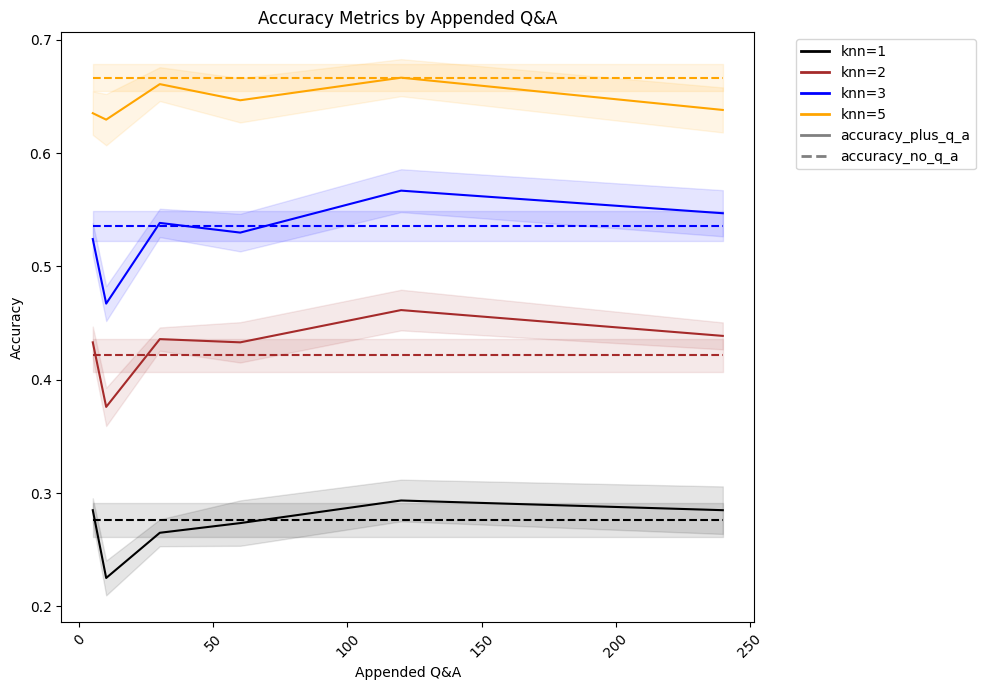

In [69]:
import pandas as pd
import matplotlib.pyplot as plt

results_random_split_df = pd.read_csv("results/random_train_split.csv")
results_random_split_df_v2 = pd.read_csv("results/random_train_split_i=4_i=15.csv")
results_random_split_df = pd.concat([results_random_split_df, results_random_split_df_v2])
results_random_split_df = results_random_split_df.rename(
    columns={"accuracy_plus_q_a_argmax": "accuracy_plus_q_a_knn=1", "accuracy_no_q_a_argmax": "accuracy_no_q_a_knn=1"})
# Group by 'appended_q_a' and calculate mean and std
# metrics = ['argmax', 'knn=2', 'knn=3', 'knn=5', 'hungarian']
metrics = ['knn=1', 'knn=2', 'knn=3', 'knn=5', ]
agg_dict = {}
for metric in metrics:
    for acc_type in ['accuracy_plus_q_a', 'accuracy_no_q_a']:
        col_name = f'{acc_type}_{metric}'
        agg_dict[col_name] = ['mean', 'std']

grouped = results_random_split_df.groupby('appended_q_a').agg(agg_dict)

# Flatten column names
grouped.columns = ['_'.join(col).strip() for col in grouped.columns.values]

# Reset index to make 'appended_q_a' a column
grouped = grouped.reset_index()

# Set up the plot
plt.figure(figsize=(10, 7))

# Define colors and line styles
# colors = {'argmax': 'blue', 'knn=2': 'green', 'knn=3': 'limegreen', 'knn=5': 'darkgreen', 'hungarian': 'red'}
colors = {'knn=1': 'black', 'knn=2': 'brown', 'knn=3': 'blue', 'knn=5': 'orange'}
linestyles = {'accuracy_plus_q_a': '-', 'accuracy_no_q_a': '--'}

# Plot each metric
for metric in metrics:
    for acc_type in ['accuracy_plus_q_a', 'accuracy_no_q_a']:
        col_name = f'{acc_type}_{metric}_mean'
        err_col = f'{acc_type}_{metric}_std'

        x = grouped['appended_q_a']
        y = grouped[col_name]
        yerr = grouped[err_col] * 0.3

        plt.plot(x, y, color=colors[metric], linestyle=linestyles[acc_type],
                 label=f'{acc_type} - {metric}')

        plt.fill_between(x, y - yerr, y + yerr, color=colors[metric], alpha=0.1)
from matplotlib.lines import Line2D

plt.xlabel('Appended Q&A')
plt.ylabel('Accuracy')
plt.title('Accuracy Metrics by Appended Q&A')

# Create custom legend for metrics (colors)
legend_elements_metrics = [Line2D([0], [0], color=color, lw=2, label=metric)
                           for metric, color in colors.items()]

# Create custom legend for accuracy types (line styles)
legend_elements_acc_type = [Line2D([0], [0], color='gray', lw=2, linestyle=linestyle, label=acc_type)
                            for acc_type, linestyle in linestyles.items()]

# Add both legend sections
plt.legend(handles=legend_elements_metrics + legend_elements_acc_type,
           bbox_to_anchor=(1.05, 1), loc='upper left',
           title='')

plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

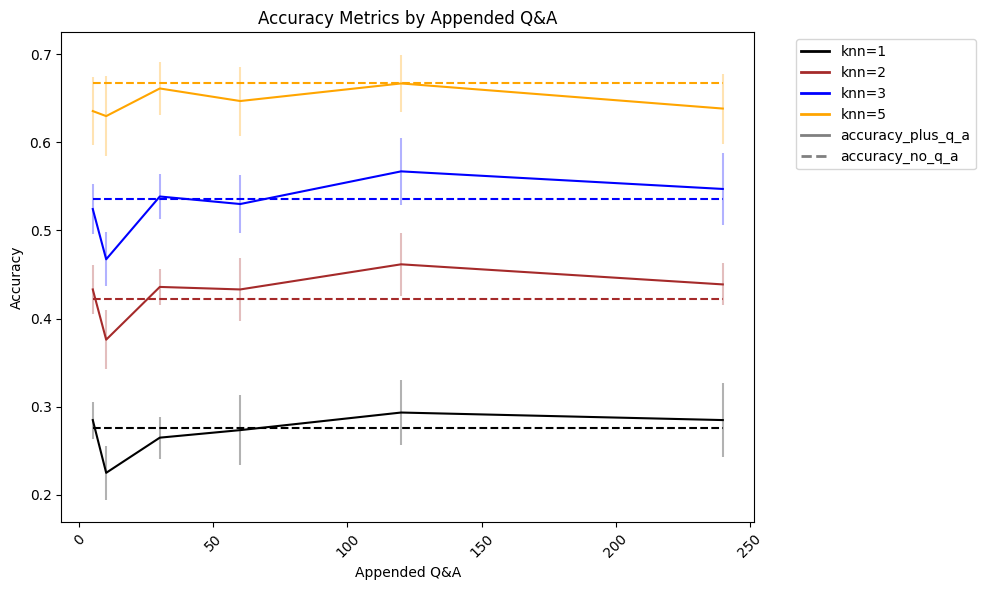

In [77]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from matplotlib.lines import Line2D

results_random_split_df = pd.read_csv("results/random_train_split.csv")
results_random_split_df_v2 = pd.read_csv("results/random_train_split_i=4_i=15.csv")
results_random_split_df = pd.concat([results_random_split_df, results_random_split_df_v2])
results_random_split_df = results_random_split_df.rename(
    columns={"accuracy_plus_q_a_argmax": "accuracy_plus_q_a_knn=1", "accuracy_no_q_a_argmax": "accuracy_no_q_a_knn=1"})

metrics = ['knn=1', 'knn=2', 'knn=3', 'knn=5']
agg_dict = {}
for metric in metrics:
    for acc_type in ['accuracy_plus_q_a', 'accuracy_no_q_a']:
        col_name = f'{acc_type}_{metric}'
        agg_dict[col_name] = ['mean', 'std']

grouped = results_random_split_df.groupby('appended_q_a').agg(agg_dict)
grouped.columns = ['_'.join(col).strip() for col in grouped.columns.values]
grouped = grouped.reset_index()

plt.figure(figsize=(10, 6))

colors = {'knn=1': 'black', 'knn=2': 'brown', 'knn=3': 'blue', 'knn=5': 'orange'}
linestyles = {'accuracy_plus_q_a': '-', 'accuracy_no_q_a': '--'}

for metric in metrics:
    for acc_type in ['accuracy_plus_q_a', 'accuracy_no_q_a']:
        col_name = f'{acc_type}_{metric}_mean'
        err_col = f'{acc_type}_{metric}_std'

        x = grouped['appended_q_a']
        y = grouped[col_name]
        yerr = grouped[err_col] * 0.6

        plt.plot(x, y, color=colors[metric], linestyle=linestyles[acc_type])

        if acc_type == 'accuracy_plus_q_a':
            plt.errorbar(x, y, yerr=yerr, color=colors[metric], fmt='none', alpha=0.3)

plt.xlabel('Appended Q&A')
plt.ylabel('Accuracy')
plt.title('Accuracy Metrics by Appended Q&A')

# Create custom legend for metrics (colors)
legend_elements_metrics = [Line2D([0], [0], color=color, lw=2, label=metric)
                           for metric, color in colors.items()]

# Create custom legend for accuracy types (line styles)
legend_elements_acc_type = [Line2D([0], [0], color='gray', lw=2, linestyle=linestyle, label=acc_type)
                            for acc_type, linestyle in linestyles.items()]

# Add both legend sections
plt.legend(handles=legend_elements_metrics + legend_elements_acc_type,
           bbox_to_anchor=(1.05, 1), loc='upper left',
           title='')

plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

/var/folders/yv/8bscwg3x6m5934xb_mry4d_m0000gr/T/ipykernel_30053/3447893592.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  temp_df['metric'] = metric
/var/folders/yv/8bscwg3x6m5934xb_mry4d_m0000gr/T/ipykernel_30053/3447893592.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  temp_df['metric'] = metric
/var/folders/yv/8bscwg3x6m5934xb_mry4d_m0000gr/T/ipykernel_30053/3447893592.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexe

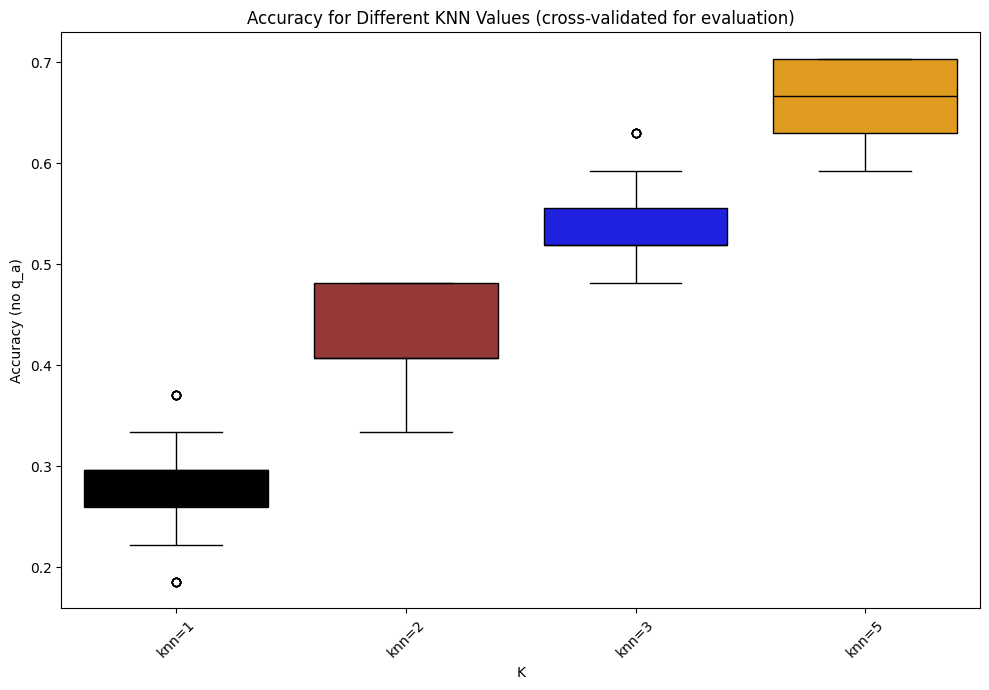

In [90]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Load the data
results_random_split_df = pd.read_csv("results/random_train_split.csv")
results_random_split_df_v2 = pd.read_csv("results/random_train_split_i=4_i=15.csv")
results_random_split_df = pd.concat([results_random_split_df, results_random_split_df_v2])
results_random_split_df = results_random_split_df.rename(columns={"accuracy_no_q_a_argmax": "accuracy_no_q_a_knn=1"})

# Prepare the data for box plot
metrics = ['knn=1', 'knn=2', 'knn=3', 'knn=5']
plot_data = []

for metric in metrics:
    col_name = f'accuracy_no_q_a_{metric}'
    temp_df = results_random_split_df[['iter', col_name]]
    temp_df['metric'] = metric
    temp_df = temp_df.rename(columns={col_name: 'accuracy'})
    plot_data.append(temp_df)

plot_df = pd.concat(plot_data, ignore_index=True)

# Set up the plot
plt.figure(figsize=(10, 7))

# Create the box plot
sns.boxplot(x='metric', y='accuracy', data=plot_df,
            palette={'knn=1': 'black', 'knn=2': 'brown', 'knn=3': 'blue', 'knn=5': 'orange'})

# Customize the plot
plt.xlabel('K')
plt.ylabel('Accuracy (no q_a)')
plt.title('Accuracy for Different KNN Values (cross-validated for evaluation)')
plt.xticks(rotation=45)

# Adjust layout and display the plot
plt.tight_layout()
plt.show()

In [87]:
# s = plot_df.groupby("metric")["accuracy"].median().to_frame().reset_index()
# s["k"] = s["metric"].str.split("=").str[1]
# s["k"] = s["k"].astype(int)
# s["random_accuracy"] = s["k"] / 27
# s["accuracy/random_accuracy"] = s["accuracy"] / s["random_accuracy"]
# s.to_clipboard()